In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
%matplotlib inline
import datetime as dt
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="Converting to PeriodArray/Index representation will drop timezone information.")
    # .. your divide-by-zero code ..


In [2]:
blue = '#0072B2'
bluegreen = '#009E73'
yellow = '#F0E442'
skyblue = '#56B4E9'
orange = '#E69F00'
vermilion = '#D55E00'

In [3]:
# 1 = positive, 0 = negative 

## Importing shapefiles

First thing we do is to import the NUTS 3 level shapefiles from Eurostat, available at [Eurostat](https://ec.europa.eu/eurostat/web/gisco/geodata/reference-data/administrative-units-statistical-units/nuts#nuts21).

In [4]:
gdf_nuts3 = gpd.read_file(
    'data/NUTS_RG_01M_2021_3857_LEVL_3.shp.zip',
    crs = "EPSG:4326"
)

In [5]:
# Filter out all countries except Norway
gdf_NOnuts3 = gdf_nuts3[gdf_nuts3.CNTR_CODE.str.contains('NO')]
# We manually filter out Svalbard and Jan Mayen as we are not interested in them
gdf_NOnuts3 = gdf_NOnuts3.query('FID != "NO0B1" and FID != "NO0B2"')
# Return to sequential index from 0 to 13
gdf_NOnuts3 = gdf_NOnuts3.reset_index()
# Set the coordinate reference system to EPSG:4326 - same as our twitter data. 
gdf_NOnuts3 = gdf_NOnuts3.to_crs("EPSG:4326")

## Twitter data

In [6]:
df_twitter = pd.read_csv(
    "data/fourth_rendition_geolocated_id_posneutral_predict.csv",
    parse_dates=[
        'created_at'
    ]
)

We group the results at a monthly resolution 

In [7]:
df_twitter_monthly = pd.DataFrame(df_twitter.copy())
df_twitter_monthly.index = df_twitter_monthly[
    'created_at'
].dt.to_period(
    'M'
)

/home/oskar/miniconda3/envs/oskar/lib/python3.10/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


In [8]:
df_monthly_results = pd.DataFrame(df_twitter_monthly.copy())
df_monthly_results = df_monthly_results.drop(
    columns={
        'username',
        'Unnamed: 0',
        'text',
        'like_count',
        'quote_count',
        'logits0',
        'logits1',
    }
)

In [9]:
# Transform the twitter data it into a GeoDataFrame with point geometry based on longitude and latitude.
gdf_monthly_results = gpd.GeoDataFrame(
    df_monthly_results,
    crs = "EPSG:4326",
    geometry=gpd.points_from_xy(
        df_twitter.longitude, 
        df_twitter.latitude
    )
).drop(
    columns={
        'latitude',
        'longitude'
    }
)
gdf_monthly_results

,id,loc,created_at,label,geometry
created_at,,,,,
2008-12,1060689807,Nordmøre,2008-12-16 14:43:57+00:00,1.0,POINT (8.97846 63.02174)
2008-12,1045067708,Lofoten,2008-12-08 14:12:10+00:00,0.0,POINT (14.66639 68.33306)
2008-12,1044682060,Oslo,2008-12-08 07:25:53+00:00,1.0,POINT (10.73897 59.91333)
2008-11,1022214006,Bergen,2008-11-25 05:33:07+00:00,0.0,POINT (5.32592 60.39431)
2008-11,1010970723,Bergen,2008-11-18 09:33:01+00:00,1.0,POINT (5.32592 60.39431)
...,...,...,...,...,...
2022-10,1581877020010901505,Oslo,2022-10-17 05:17:26+00:00,1.0,POINT (10.73897 59.91333)
2022-10,1581874121306095616,Trondheim,2022-10-17 05:05:54+00:00,0.0,POINT (10.39519 63.43057)
2022-10,1581870849753174016,Grimstad,2022-10-17 04:52:54+00:00,1.0,POINT (8.71283 58.28400)


In [10]:
# Spatial joins https://geopandas.org/docs/user_guide/mergingdata.html#spatial-joins
# Basically, we add an attribute for each city related to the county the coordinate is located inside.
gdf_monthly_county_results = gdf_monthly_results.sjoin(
    gdf_NOnuts3, 
    how = "inner", 
    predicate = 'intersects'
).set_index(
    'NUTS_NAME'
).drop(
    columns={
        'index_right',
        'NUTS_ID',
        'LEVL_CODE',
        'CNTR_CODE',
        'NAME_LATN',
        'index',
        'MOUNT_TYPE',
        'URBN_TYPE',
        'COAST_TYPE',
        'FID',
        'loc'
    }
).reset_index(
)

gdf_monthly_county_results
# Summate the different cities within each county
#gdf_frequency_county = gdf_twitter_with_county.groupby(
#    'NUTS_NAME'
#).sum()
#gdf_frequency_county.head(5)

,NUTS_NAME,id,created_at,label,geometry
0,Møre og Romsdal,1060689807,2008-12-16 14:43:57+00:00,1.0,POINT (8.97846 63.02174)
1,Møre og Romsdal,991702034,2008-11-05 14:23:09+00:00,1.0,POINT (8.97846 63.02174)
2,Møre og Romsdal,878071117,2008-08-05 08:56:27+00:00,1.0,POINT (8.97846 63.02174)
3,Møre og Romsdal,817334892,2008-05-22 11:36:20+00:00,1.0,POINT (8.97846 63.02174)
4,Møre og Romsdal,3799885054,2009-09-06 15:39:43+00:00,1.0,POINT (8.65267 62.64703)
...,...,...,...,...,...
63800,Viken,1582315632577896449,2022-10-18 10:20:19+00:00,0.0,POINT (10.17564 59.69649)
63801,Viken,1582308145551925250,2022-10-18 09:50:34+00:00,1.0,POINT (10.17564 59.69649)
63802,Viken,1582133975992086529,2022-10-17 22:18:29+00:00,1.0,POINT (11.04515 59.95341)
63803,Viken,1582091278925242370,2022-10-17 19:28:49+00:00,1.0,POINT (10.17564 59.69649)


### County level

In [11]:
county_list = [
    'Agder',
    'Troms og Finnmark',
    'Nordland',
    'Møre og Romsdal',
    'Vestland',
    'Rogaland',
    'Vestfold og Telemark',
    'Viken',
    'Innlandet',
    'Oslo',
    'Trøndelag'
]

In [12]:
for county in county_list:
    gdf = gdf_monthly_county_results.loc[gdf_monthly_county_results['NUTS_NAME'] == str(county)]
    print(county + ': ' + str(gdf.label.count()))

Agder: 770
Troms og Finnmark: 1122
Nordland: 915
Møre og Romsdal: 873
Vestland: 8354
Rogaland: 4280
Vestfold og Telemark: 1257
Viken: 4023
Innlandet: 2591
Oslo: 32901
Trøndelag: 6718


In [13]:
gdf_monthly_county_results

,NUTS_NAME,id,created_at,label,geometry
0,Møre og Romsdal,1060689807,2008-12-16 14:43:57+00:00,1.0,POINT (8.97846 63.02174)
1,Møre og Romsdal,991702034,2008-11-05 14:23:09+00:00,1.0,POINT (8.97846 63.02174)
2,Møre og Romsdal,878071117,2008-08-05 08:56:27+00:00,1.0,POINT (8.97846 63.02174)
3,Møre og Romsdal,817334892,2008-05-22 11:36:20+00:00,1.0,POINT (8.97846 63.02174)
4,Møre og Romsdal,3799885054,2009-09-06 15:39:43+00:00,1.0,POINT (8.65267 62.64703)
...,...,...,...,...,...
63800,Viken,1582315632577896449,2022-10-18 10:20:19+00:00,0.0,POINT (10.17564 59.69649)
63801,Viken,1582308145551925250,2022-10-18 09:50:34+00:00,1.0,POINT (10.17564 59.69649)
63802,Viken,1582133975992086529,2022-10-17 22:18:29+00:00,1.0,POINT (11.04515 59.95341)
63803,Viken,1582091278925242370,2022-10-17 19:28:49+00:00,1.0,POINT (10.17564 59.69649)


/home/oskar/miniconda3/envs/oskar/lib/python3.10/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
/home/oskar/miniconda3/envs/oskar/lib/python3.10/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


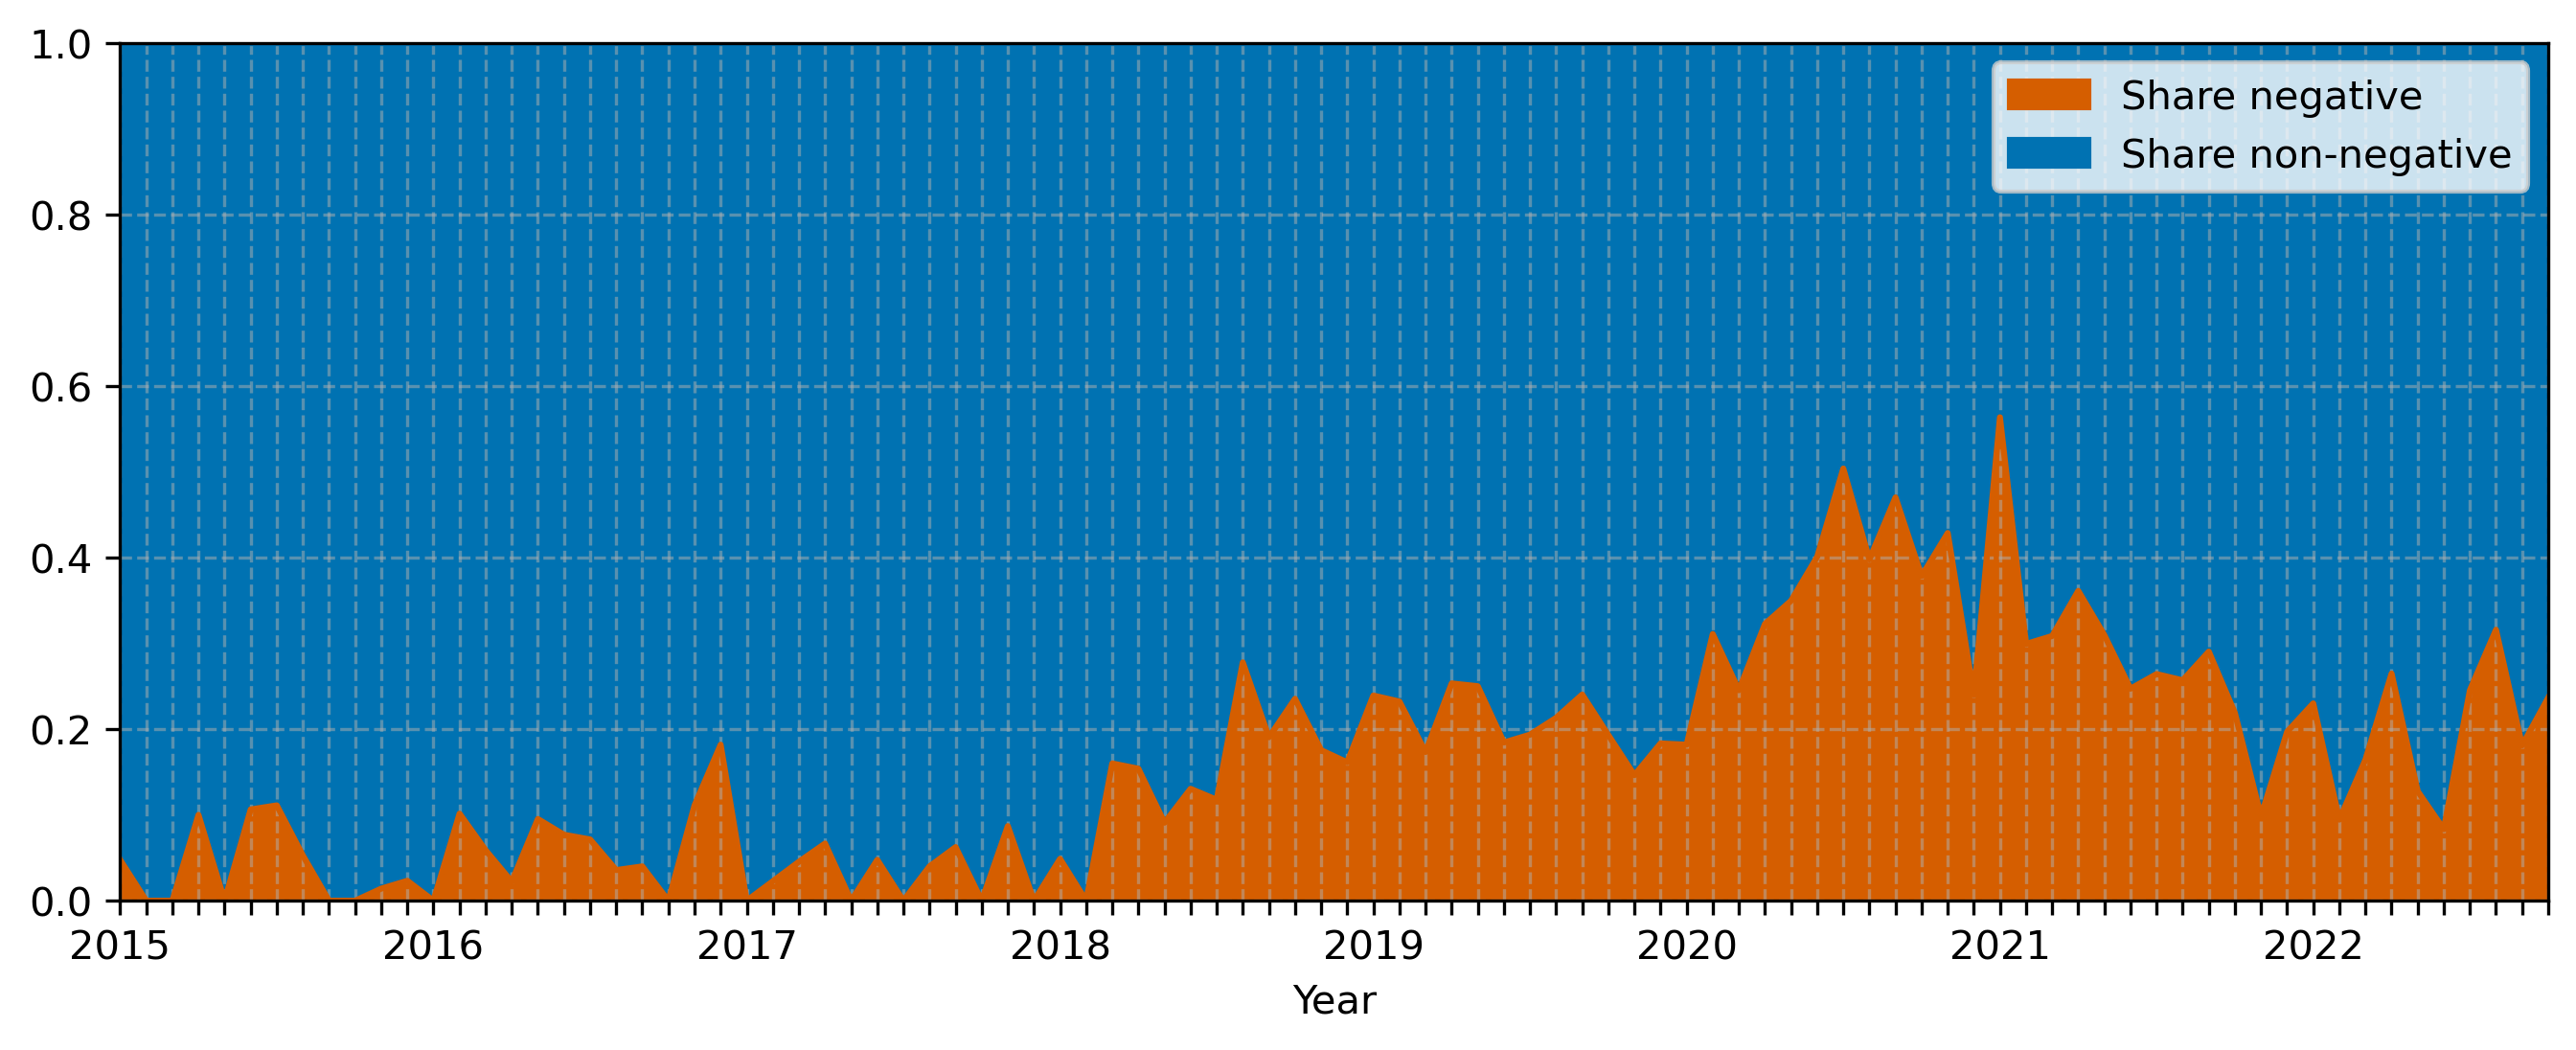

In [42]:
fig, ax = plt.subplots(figsize=(2.5*3.54,3.54), dpi=300,layout="constrained")
tick_spacing = 1


# 1 = positive, 0 = negative 
gdf = gdf_monthly_county_results.loc[gdf_monthly_county_results['NUTS_NAME'] == str(county)]
    
temp = gdf.assign(
    year_month = lambda x: x.created_at.dt.to_period('M') 
).groupby(
    'year_month'
).sum(
).rename(
    columns={
        'label' : 'non_negative_tweets'
    }
).assign(
    total_tweets = gdf.assign(year_month = lambda x: x.created_at.dt.to_period('M')).groupby('year_month').count().label,
    negative_tweets = lambda x : x.total_tweets - x.non_negative_tweets,
    share_negative = lambda x : x.negative_tweets/x.total_tweets,
    share_non_negative = lambda x : x.non_negative_tweets/x.total_tweets
)

temp.plot.area(
    y = ['share_negative','share_non_negative'],
    #stacked=True,
    ax = ax,
    color = [vermilion,blue],
    label = ['Share negative','Share non-negative']
)


ax.set_xlim([dt.date(2015, 1,1), (gdf.created_at.iloc[-1])])
#ax.set_xlim(left = '2014-03')
ax.set_ylim(0,1)
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax.grid(alpha = 0.5, linestyle = '--')
ax.set_xlabel('Year')

plt.savefig('figures/monthly_shares.pdf', bbox_inches = 'tight')

In [43]:
for county in county_list:
    fig, ax = plt.subplots(figsize=(3*3.54,3.54), dpi=300,layout="constrained")
    tick_spacing = 12
    # 1 = positive, 0 = negative 
    gdf = gdf_monthly_county_results.loc[gdf_monthly_county_results['NUTS_NAME'] == str(county)]
        
    temp = gdf.assign(
        year_month = lambda x: x.created_at.dt.to_period('M') 
    ).groupby(
        'year_month'
    ).sum(
    ).rename(
        columns={
            'label' : 'non_negative_tweets'
        }
    ).assign(
        total_tweets = gdf.assign(year_month = lambda x: x.created_at.dt.to_period('M')).groupby('year_month').count().label,
        negative_tweets = lambda x : x.total_tweets - x.non_negative_tweets,
        share_negative = lambda x : x.negative_tweets/x.total_tweets,
        share_non_negative = lambda x : x.non_negative_tweets/x.total_tweets
    )
    
    temp.plot.area(
        y = ['share_negative','share_non_negative'],
        stacked=True,
        ax = ax,
        color = [vermilion,blue]
    )
    
    ax.set_xlim([dt.date(2015, 1,1), (gdf.created_at.iloc[-1])])
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_ylim(0,1)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.grid()
    
    #plt.savefig('figures/bar_time_'+str(county.replace(" ", ""))+'.pdf',bbox_inches='tight')
    #plt.savefig('figures/temporal_bar_'+str(county.replace(" ", ""))+'.pdf',bbox_inches='tight')
    #plt.savefig('figures/png/temporal_bar_'+str(county.replace(" ", ""))+'.png',bbox_inches='tight', facecolor='white', edgecolor='black')
    plt.close()
    

/home/oskar/miniconda3/envs/oskar/lib/python3.10/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
/home/oskar/miniconda3/envs/oskar/lib/python3.10/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
/home/oskar/miniconda3/envs/oskar/lib/python3.10/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
/home/oskar/miniconda3/envs/oskar/lib/python3.10/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
/home/oskar/miniconda3/envs/oskar/lib/python3.10/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation

/home/oskar/miniconda3/envs/oskar/lib/python3.10/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
/home/oskar/miniconda3/envs/oskar/lib/python3.10/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
/home/oskar/miniconda3/envs/oskar/lib/python3.10/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
/home/oskar/miniconda3/envs/oskar/lib/python3.10/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
/home/oskar/miniconda3/envs/oskar/lib/python3.10/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation

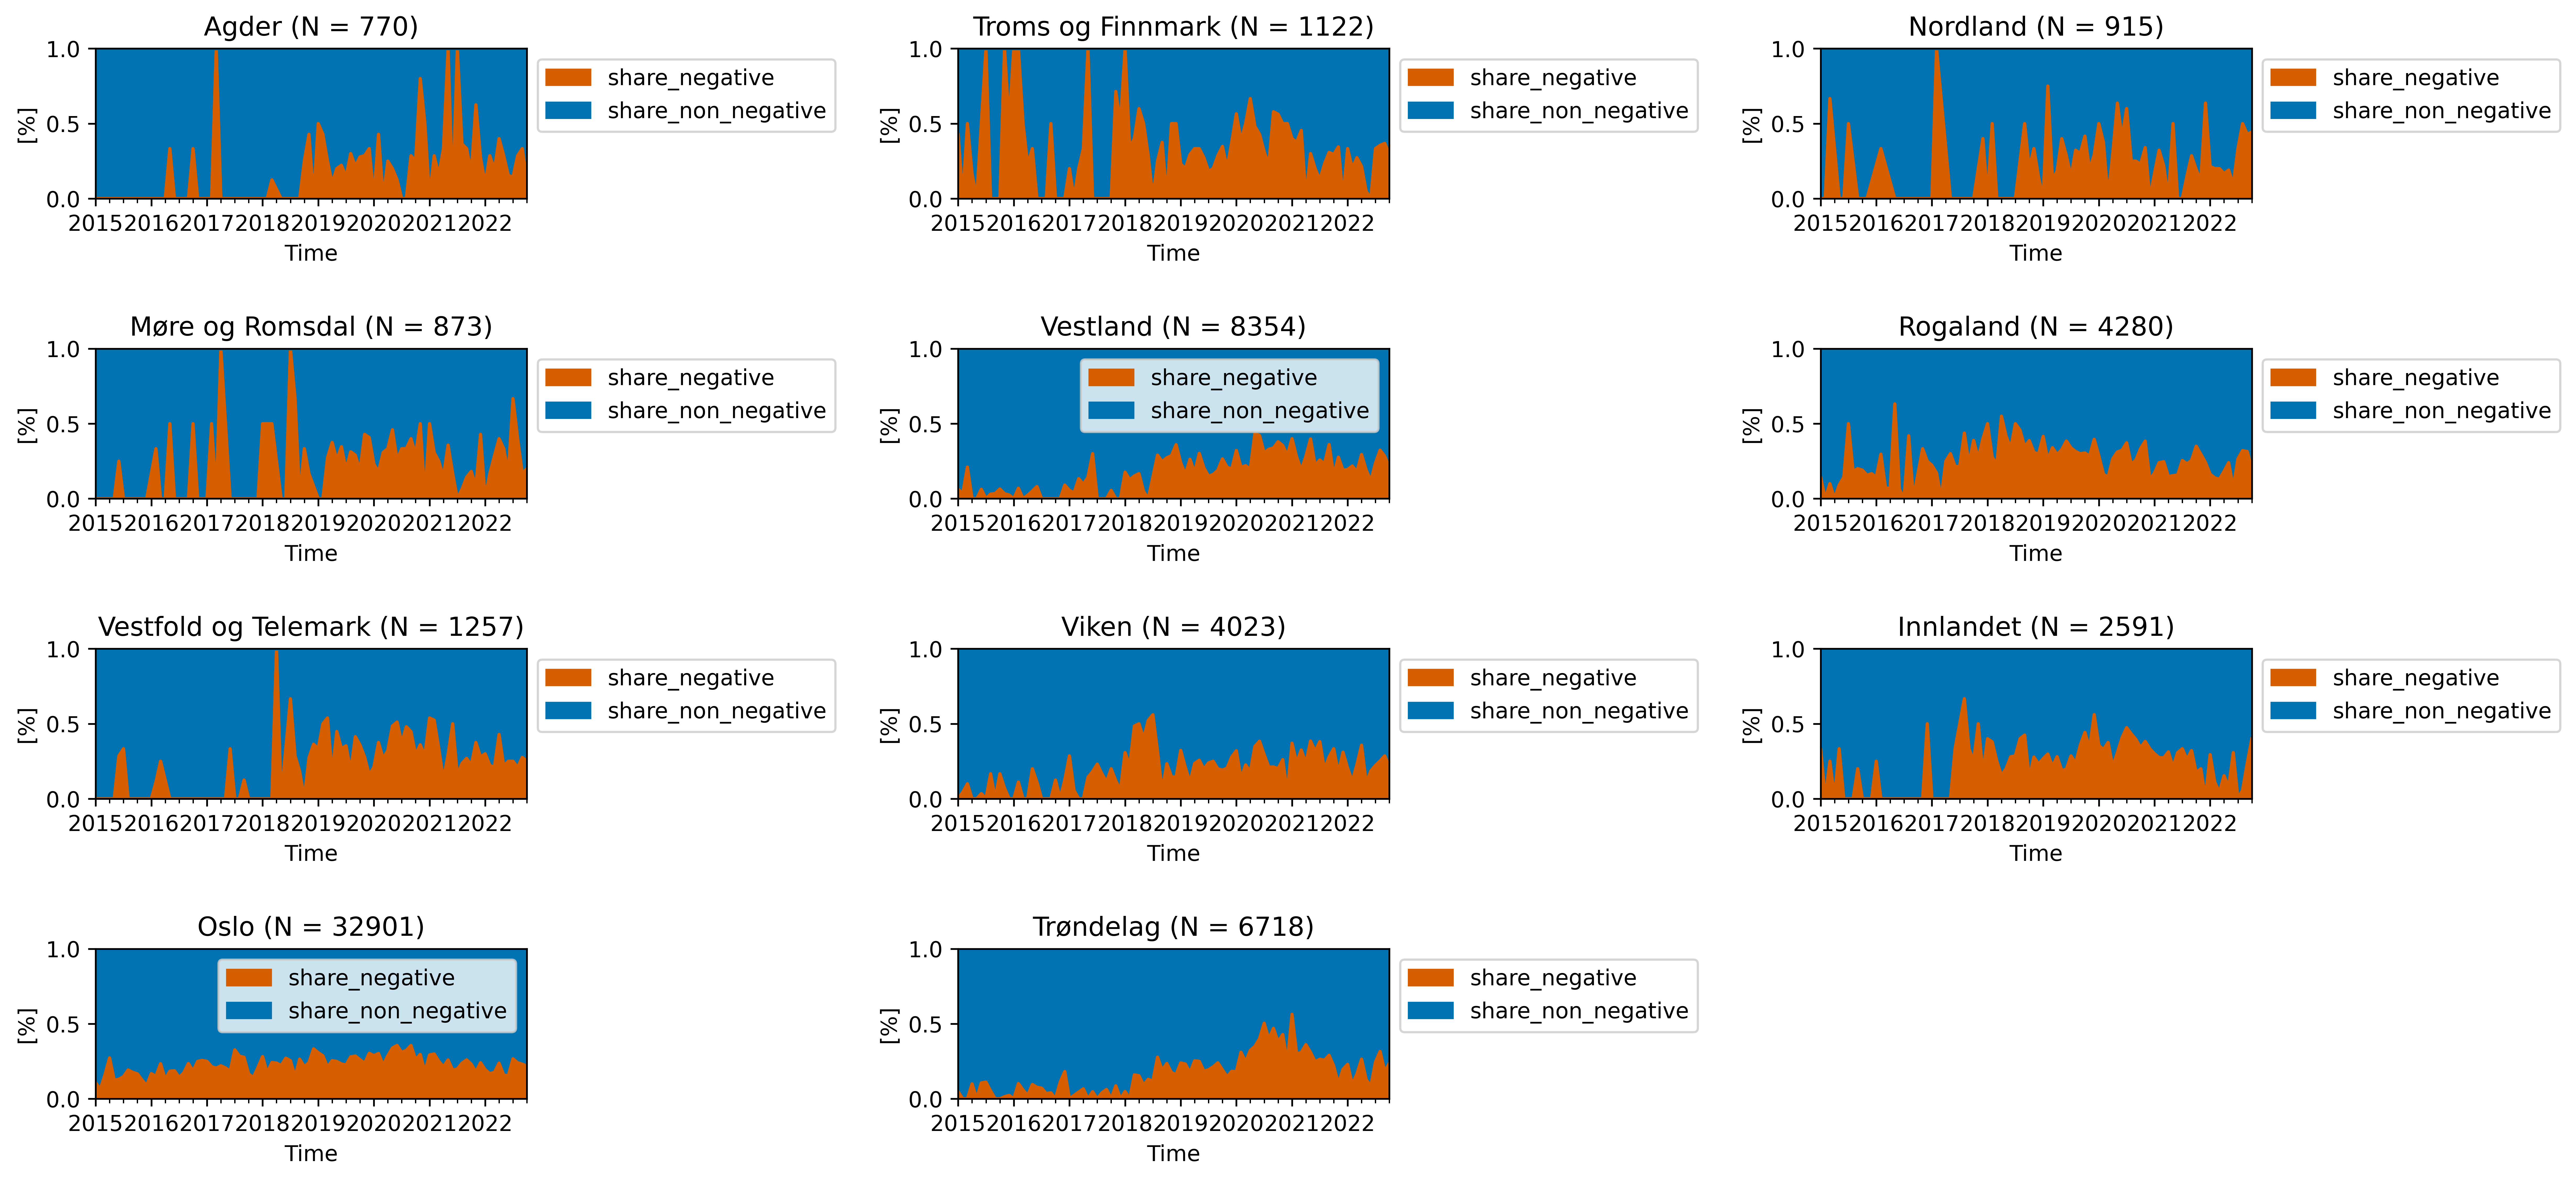

In [44]:
# 1 = positive, 0 = negative 
row_nr = 0
column_nr = 0
fig = plt.figure(figsize=(5*3.54,2.5*3.54), dpi=600)
tick_spacing = 12
gs = fig.add_gridspec(4,3, wspace = 1, hspace = 1)

for county in county_list:
    ax1 = fig.add_subplot(gs[row_nr,column_nr])
    gdf = gdf_monthly_county_results.loc[gdf_monthly_county_results['NUTS_NAME'] == str(county)]
        
    temp = gdf.assign(
        year_month = lambda x: x.created_at.dt.to_period('M') 
    ).groupby(
        'year_month'
    ).sum(
    ).rename(
        columns={
            'label' : 'non_negative_tweets'
        }
    ).assign(
        total_tweets = gdf.assign(year_month = lambda x: x.created_at.dt.to_period('M')).groupby('year_month').count().label,
        negative_tweets = lambda x : x.total_tweets - x.non_negative_tweets,
        share_negative = lambda x : x.negative_tweets/x.total_tweets,
        share_non_negative = lambda x : x.non_negative_tweets/x.total_tweets
    )
    
    temp.plot.area(
        y = ['share_negative','share_non_negative'],
        stacked=True,
        ax = ax1,
        color = [vermilion,blue],
        #figsize=(3.54,3.54)
    )
    
    column_nr += 1
    if column_nr == 3:
        column_nr = 0
        row_nr += 1
    
    ax1.set_xlabel('Time')
    ax1.set_ylabel('[%]')
    ax1.legend(bbox_to_anchor =(1,1))
    ax1.set_title(str(county) + " (N = " + str(gdf.label.count()) + ")")
    ax1.set_xlim([dt.date(2015, 1,1), (gdf.created_at.iloc[-1])])
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax1.set_ylim(0,1)
    #ax1.grid()
    
plt.savefig('figures/monthly_shares_gridspec.pdf', bbox_inches='tight')